# Awesome NTDS project 

bla bla bla

## 1. Dependencies

*Matplotlib* do not cope well with large scale 3D data visualization. This can be overcomed by the use of `mayavi` package (*build on top of OpenGL pipeline*). It can be installed on your machine with the following commands (based on [#473](https://github.com/enthought/mayavi/issues/473#issuecomment-352033311)):

```
$ conda install -c clinicalgraphics vtk=7.1.0
$ pip install git+https://github.com/enthought/pyface.git
$ pip install git+https://github.com/enthought/traitsui.git
$ pip install git+https://github.com/enthought/mayavi.git
```

In order to use it in a `jupyter` notebook, some extension need to be installed. The command listed below will do it:

```
$ jupyter nbextension install --py mayavi --user
```


In [2]:
import platform
from utils import *
from mesh import *
from deformation import *
import numpy as np
import os
from scipy import sparse
# Mayavi stuff, can be a bit tricky on OSX
# OSX: x3d interactive backend but still buggy
# Linux: png Offscreen rendering since x3d backend schrinks when plotted
backend = 'x3d' if platform.system() == 'Darwin' else 'png'
from mayavi import mlab
mlab.init_notebook(backend, local=False)

# Base folder where data are located, user-specific since location
data_folder = '../data'

Notebook initialized with png backend.


## 2. Data Analysis

Can we recover some morphological properties such as facial expressions, or ethnies within the dataset ?

## 3. Graph-based deformation learning

In this section, the deformation between different facial expressions will be investigated under two formulations:

- Deformation field
- Constrainted reconstruction

### 3.1 Deformation field

Every meshes in the dataset are densely registered, all the vertices have the same semantics. Therefore the targeted surface $\boldsymbol{x}^t$ can be defined with respect of the source $\boldsymbol{x}^s$ and a deformation field $\boldsymbol{d}$.

$$ \boldsymbol{x}^t = \boldsymbol{x}^s + \boldsymbol{d} $$

The goal is to estimate the deformation field only using a sparse subset of $K$ target's vertices. The deformation learning can be formulated using graph-based tool as follow:

$$ \boldsymbol{d}^*_i = argmin \quad \left|\left| M \left(\boldsymbol{x}_i^s + \boldsymbol{d}_i \right) - \boldsymbol{x}_i^t \right|\right|_2^2 + \alpha \boldsymbol{d}_i^{\top}\boldsymbol{L} \boldsymbol{d}_i $$

where:

- $\boldsymbol{x}_i^s \in \mathbb{R}^{N \times 1}, i \in \{x,y,z \}$ the source's component
- $\boldsymbol{x}_i^s \in \mathbb{R}^{K \times 1}, i \in \{x,y,z \}$ the target's component
- $\boldsymbol{M} \in \mathbb{R}^{K \times M}$ a selection operator
- $\boldsymbol{L} \in \mathbb{R}^{N \times N}$ the laplacian operator
- $\boldsymbol{d}_i \in \mathbb{R}^{N \times 1}, i \in \{x,y,z\}$ the deformation field's component

#### 3.1.1. Anchor selection

In order to have constraints over all surface's points, the anchors are selected using a downsampled version of the original mesh. The sources is decimated by a factor of $20$ using algorithm based on [Surface Simplification Using Quadric Error Metrics](https://www.ri.cmu.edu/pub_files/pub2/garland_michael_1997_1/garland_michael_1997_1.pdf).
The selection operator is build from the anchor's indexes $a_i \in C$ computed previously. The operator $\boldsymbol{M}$ is defined as:

$$ M_{ij} = \begin{cases} 1 & \mbox{if } j \in C \\ 0 & otherwise \end{cases} $$

In [3]:
# Load source + target meshes + anchors
tri = utils.load_triangulation(os.path.join(data_folder, 'FWTri/fw_triangulation.tri'))
meshes = utils.load_meshes(os.path.join(data_folder, 'FWMesh/115_shape.bs'), [0, 22])
anchors = utils.load_anchor_point(os.path.join(data_folder, 'anchors.cfg'))

In [17]:
# Create mesh instances for source and target surface
mesh_xs = Mesh(meshes[0], tri)
mesh_xt = Mesh(meshes[1], tri)
N = meshes[0].shape[0]
# Dump meshes into .obj file
mesh_xs.save('source.obj')
mesh_xt.save('target.obj')
# Define ground-truth
d_true = mesh_xt.vertex - mesh_xs.vertex
d_norm = np.linalg.norm(d_true, axis=1)


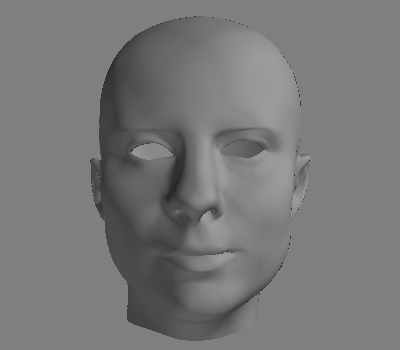

In [6]:
# Source surface
mlab.clf()
color = (0.5, 0.5, 0.5)
trimesh_xs = mlab.triangular_mesh(mesh_xs.vertex[:,0], mesh_xs.vertex[:,1], mesh_xs.vertex[:,2], mesh_xs.tri, color=color)
mlab.view(0,0)
trimesh_xs


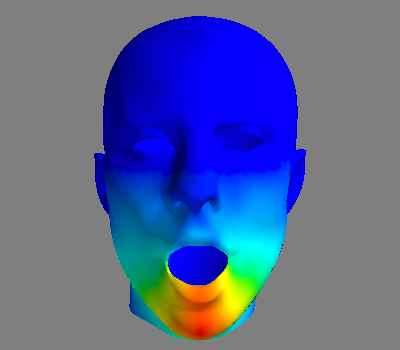

In [19]:
# Target surface, with displacment color coded (Red = large).  
mlab.clf()
trimesh_xt = mlab.triangular_mesh(mesh_xt.vertex[:,0], mesh_xt.vertex[:,1], mesh_xs.vertex[:,2], mesh_xt.tri, scalars=d_norm)
mlab.view(0, 0)
trimesh_xt

In [198]:
# 1) create selection mask
K = len(anchors)
ridx = [k for k in range(K)]
cidx = anchors
data = [1.0] * K
M = sparse.coo_matrix((data, (ridx, cidx)), shape=(K, N), dtype=np.float32)
# 2) Comptue laplacian
_,_, Lap = mesh_xs.compute_laplacian('cotan')
# 3) Compute target
Xs = mesh_xs.vertex
Xt = M.dot(mesh_xt.vertex)

In [199]:
# 4) Estimate deformation field without regularization
estm_xt, d = deform_regularized_anchor(Xs, Xt, M, Lap, 0.05)
# Error
err = np.linalg.norm(estm_xt - mesh_xt.vertex, axis=1)
e = np.mean(err)
print('Mean error of %f, for %d anchors' % (e, K))
m = Mesh(estm_xt, tri)
m.save('deformation_field.obj')

Mean error of 0.002153, for 587 anchors



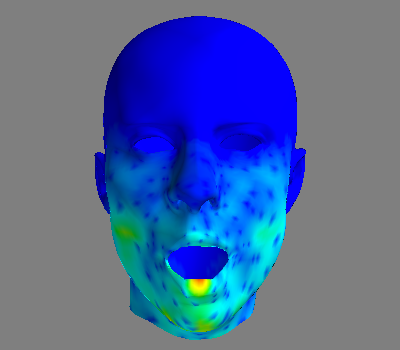

In [200]:
mlab.clf()
trimesh_xt_estm = mlab.triangular_mesh(estm_xt[:,0], estm_xt[:,1], estm_xt[:,2], mesh_xt.tri, scalars=err)
mlab.view(0, 0)
trimesh_xt_estm

### 3.2 Least-Square Mesh







In [30]:
# Define only anchors around the lips
anchorsIdx = anchors
anchorsIdx = [1089, 1054, 1148, 1322, 497, 511, 3865,
              477, 9053,1902,6754,9175,6764,1917,2744,8043,2514, #Chin
              10892, 4367, 7330, 9456,
              703, 4293, 7187, 2128, # Eyebrows
              323, 9397, 8972,1748, # Nose
              10308, 3237, 3205, 6081, 6091,6124,8832, 6611, 1827, 3582, 402, 3584, # Mouth region
              3271, 10313, 8808, 8825, 6159, 8842, 8809, 10326,# Inner
              5586, 5601,11482,10039, #Neck
              3003, 5339, 8290, 5331, 8458, # Top head
              5550, 6801, 10543, 6714] # Cheeks
anchors_pts = mesh_xt.vertex[anchorsIdx, :]
# Deform
estm_xt = deform_mesh(mesh_xs, anchors_pts, anchorsIdx, 1.0)
# Error
err = np.linalg.norm(estm_xt - mesh_xt.vertex, axis=1)
e = np.mean(err)
print('Mean error: %f, for %d anchors' % (e, len(anchorsIdx)))

Mean error: 0.004994, for 62 anchors



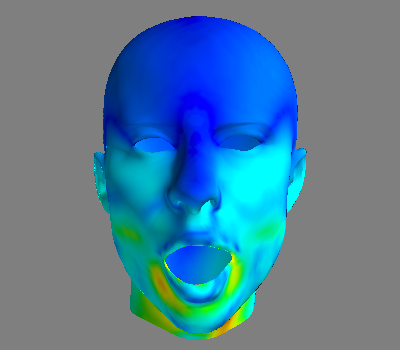

In [31]:
mlab.clf()
trimesh_xt_estm = mlab.triangular_mesh(estm_xt[:,0], estm_xt[:,1], estm_xt[:,2], mesh_xt.tri, scalars=err)
mlab.view(0, 0)
trimesh_xt_estm

### 3.3 Laplacian Operator

During our experiments, it has be seen that response to the Laplacian change depending on the tessalation of the surface.

In [201]:
# Load mesh
sph = Mesh()
sph.load(os.path.join(data_folder, 'sphere_unregular.obj'))
# Compute two variant of laplacian
_,_, lap_comb = sph.compute_laplacian('combinatorial')
_,_, lap_cotan = sph.compute_laplacian('cotan')
# Get eigen vectors
import scipy.sparse.linalg

_, eigv_comb = sparse.linalg.eigsh(lap_comb, which='SM')
_, eigv_cotan = sparse.linalg.eigsh(lap_cotan, which='SM')


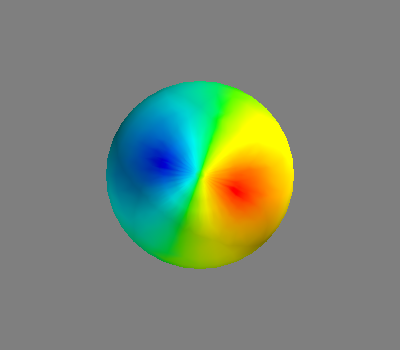

In [202]:
idx = 2
mlab.clf()
trimesh_comb = mlab.triangular_mesh(unreg_sph.vertex[:,0], unreg_sph.vertex[:,1], unreg_sph.vertex[:,2], unreg_sph.tri, scalars=eigv_comb[:,idx])
mlab.view(90, 90, 7.0)
trimesh_comb


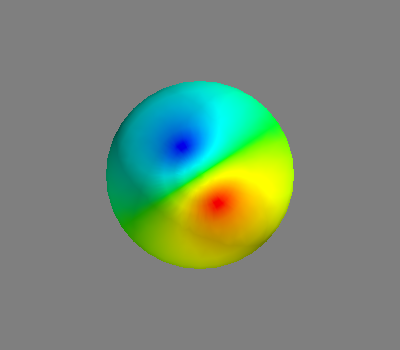

In [203]:
mlab.clf()
trimesh_cotan = mlab.triangular_mesh(unreg_sph.vertex[:,0], unreg_sph.vertex[:,1], unreg_sph.vertex[:,idx], unreg_sph.tri, scalars=eigv_cotan[:,2])
mlab.view(90, 90, 7.0)
trimesh_cotan

## 4. Conclusions

bla bla